In [2]:
import numpy as np
import pandas as pd
import csv
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
'''
Utility Functions
'''
# DATA: months since 2012, X coord, Y coord
def split(X, tr_size):
    Y = np.copy(X)
    np.random.shuffle(Y)
    break_pt = tr_size * np.shape(Y)[0]
    return Y[:break_pt,:], Y[break_pt:,:]

# implementation notes: set NaN to mean
def normalize_features(X_train):
    mean_X_train = np.nanmean(X_train, 0)
    for i in xrange(np.shape(X_train)[1]):
        col = X_train[:,i]
        col[ np.isnan(col) ] = mean_X_train[i]
    std_X_train = np.std(X_train, 0)
    std_X_train[ std_X_train == 0 ] = 1
    X_train_normalized = (X_train - mean_X_train) / std_X_train
    return X_train_normalized

# Note: bucket edits in place
def bucket(X, cols, num_buckets):
    Y = np.copy(X)
    for col in cols:
        buckets = np.linspace(np.min(X[:,col]), np.max(X[:,col]), num=num_buckets+1)
        for i in xrange(num_buckets):
            X_col = Y[:,col]
            X_col[ (buckets[i] <= X_col) & (X_col <= buckets[i+1])] = i
            Y[:,col] = X_col
    return Y

def rmse(predict, true):
    return np.sqrt(1.0/np.shape(predict)[0] * np.sum(np.square(predict - true)))

In [21]:
'''
Read in data
'''

import re
import warnings

bos_file = '../data/boston.csv'
target_type = str  # The desired output type

with warnings.catch_warnings(record=True) as ws:
    warnings.simplefilter("always")

    bos_data = pd.read_csv(bos_file, sep=",", header=0)
    print("Warnings raised:", ws)
    # We have an error on specific columns, try and load them as string
    for w in ws:
        s = str(w.message)
        print("Warning message:", s)
        match = re.search(r"Columns \(([0-9,]+)\) have mixed types\.", s)
        if match:
            columns = match.group(1).split(',') # Get columns as a list
            columns = [int(c) for c in columns]
            print("Applying %s dtype to columns:" % target_type, columns)
            bos_data.iloc[:,columns] = bos_data.iloc[:,columns].astype(target_type)

'''
Featurize data
'''
# temporal features
# day of week
day = np.array(bos_data.DAY_WEEK)
day[ day == "Sunday"] = 0
day[ day == "Monday"] = 1
day[ day == "Tuesday"] = 2
day[ day == "Wednesday"] = 3
day[ day == "Thursday"] = 4
day[ day == "Friday"] = 5
day[ day == "Saturday"] = 6

date_time = np.array([x.split() for x in bos_data.FROMDATE])
date = date_time[:,0]
time = date_time[:,1]
tod = date_time[:,2]

# month, day, year
date = np.array([x.split('/') for x in date])
month = [int(x) for x in date[:,0]]
dom = [int(x) for x in date[:,1]]
year = [int(x) for x in date[:,2]]
time_feat = np.subtract(year, 2012)*12 + month

# time of day
time_c = [x.split(':') for x in time]
time = [int(x[1]) if (y == 'AM' and int(x[0]) == 12) else 60*int(x[0])+int(x[1]) 
        if (y =='AM' and int(x[0]) != 12) or (int(x[0]) == 12 and y == 'PM') else 12*60+60*int(x[0])+int(x[1]) 
        for x,y in zip(time_c, tod)]

data_unnorm = np.transpose(np.vstack((time_feat, bos_data.X, bos_data.Y))).astype(float)
# remove NaNs
good_data = data_unnorm[~(np.isnan(data_unnorm[:,1]))]

('Warnings raised:', [<warnings.WarningMessage object at 0x7fcc49408a50>])
('Warning message:', 'Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.')
("Applying <type 'str'> dtype to columns:", [10])


In [22]:
'''
Count data for each cell
'''
n_buckets = 5
data_b = bucket(good_data, [1, 2], n_buckets)

years = [2012, 2013, 2014, 2015]
n_time = int(data_b[np.argmax(data_b[:,0])][0])

buckets = np.zeros((n_time, n_buckets, n_buckets))
buckets2 = np.zeros((n_buckets * n_buckets * n_time, 4))

# divide the data up by year and month
for i in xrange(n_time):
    for j in xrange(n_buckets):
        for k in xrange(n_buckets):
            count = data_b[ (data_b[:,0] == i+1) & 
                            (data_b[:,1] == j) & 
                            (data_b[:,2] == k)]
            buckets[i][j][k] = np.size(count,0)
            buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][0] = i
            buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][1] = j
            buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][2] = k
            buckets2[i*(n_buckets * n_buckets)+j*(n_buckets)+k][3] = np.size(count,0)

In [31]:
'''
Split into test and train, r for random
'''
train_r, test_r = split(buckets2, .8)
train_rt = train_r[:,[3]]
train_r = train_r[:,[0,1,2]]
test_rt = test_r[:,[3]]
test_r = test_r[:,[0,1,2]]

'''
Holdout most recent year
'''
train, test = buckets2[:875,:], buckets2[875:,:]
train_t = train[:,[3]]
train = train[:,[0,1,2]]
test_t = test[:,[3]]
test = test[:,[0,1,2]]

In [250]:
'''
Bucketed Ridge Regression
'''

time_feats = np.linspace(0, 36, 37) # months since 07/2012

ridges = np.zeros((n_buckets, n_buckets))

for i in xrange(n_buckets):
    for j in xrange(n_buckets):
        geon_data = np.transpose(np.vstack((time_feats, np.reshape(buckets[:,:,i,j], (1, -1))[0][6:-5]))) # starts in July 2012 up to most recent
        train, test = split(geon_data, .8)
        model = lm.Ridge()
        model.fit(np.reshape(train[:,0], (np.shape(train)[0],1)), np.reshape(train[:,1], (np.shape(train)[0],1)))
        predicts = model.predict(np.reshape(test[:,0], (np.shape(test)[0],1)))
        ridges[i][j] = rmse(predicts, np.reshape(test[:,1], (np.shape(test)[0],1)))
        #model.score(np.reshape(test[:,0], (np.shape(test)[0],1)), np.reshape(test[:,1], (np.shape(test)[0],1)))

print "Average error:", np.sum(ridges)/(n_buckets**2)
print ridges

Average error: 38.631766489
[[   5.97571921   13.34448447    1.08614338   32.90435182    6.41121614]
 [  33.07257048   39.49869463   64.47793845   68.06992671    3.79555746]
 [   2.32066044   86.72856072  164.64222507  284.93231177   78.42032413]
 [   0.            9.69862218   19.09162888    9.5967189    35.74033367]
 [   0.            0.            2.47574648    0.            3.51042722]]


In [251]:
bucket_sizes = [1, 5, 10, 25, 50]
errors = []

for size in bucket_sizes:
    data_b = bucket(good_data, [5, 6], size)
    buckets = np.zeros((len(years), n_mos, size, size))

    # divide the data up by year and month
    for h in xrange(len(years)):
        data_unnorm[data_unnorm[:,0] == 2012]
        for i in xrange(n_mos):
            for j in xrange(size):
                for k in xrange(size):
                    count = data_b[(data_b[:,0] == years[h]) & 
                                                      (data_b[:,1] == i+1) & 
                                                      (data_b[:,5] == j) & 
                                                      (data_b[:,6] == k)]
                    buckets[h][i][j][k] = np.size(count,0)
    
    ridges = np.zeros((size, size))

    for i in xrange(size):
        for j in xrange(size):
            geon_data = np.transpose(np.vstack((time_feats, np.reshape(buckets[:,:,i,j], (1, -1))[0][6:-5]))) # starts in July 2012 up to most recent
            train, test = split(geon_data, .8)
            model = lm.Ridge()
            model.fit(np.reshape(train[:,0], (np.shape(train)[0],1)), np.reshape(train[:,1], (np.shape(train)[0],1)))
            predicts = model.predict(np.reshape(test[:,0], (np.shape(test)[0],1)))
            ridges[i][j] = rmse(predicts, np.reshape(test[:,1], (np.shape(test)[0],1)))
            #model.score(np.reshape(test[:,0], (np.shape(test)[0],1)), np.reshape(test[:,1], (np.shape(test)[0],1)))

    print "Average error:", np.sum(ridges)/(size**2)
    errors.append(np.sum(ridges)/(size**2))

Average error: 676.610276256
Average error: 36.8720866748
Average error: 15.6527848706
Average error: 3.55986509579
Average error: 1.29333739045


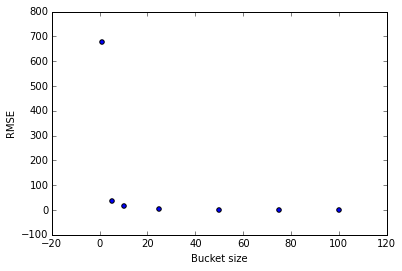

In [260]:
plt.scatter(bucket_sizes + bucket_sizes2, errors+ errors2)
plt.xlabel('Bucket size')
plt.ylabel('RMSE')
plt.show()

In [110]:
data = normalize_features(data_unnorm)
data_b = bucket(data, [5, 6], 30)
train, test = split(data_b, .8)

[-3.17778786 -2.9469638  -2.71613973 -2.48531566 -2.25449159 -2.02366753
 -1.79284346 -1.56201939 -1.33119533 -1.10037126 -0.86954719 -0.63872312
 -0.40789906 -0.17707499  0.05374908  0.28457315  0.51539721  0.74622128
  0.97704535  1.20786941  1.43869348  1.66951755  1.90034162  2.13116568
  2.36198975  2.59281382  2.82363789  3.05446195  3.28528602  3.51611009
  3.74693416  3.97775822]
[-2.9663754  -2.79429515 -2.6222149  -2.45013466 -2.27805441 -2.10597416
 -1.93389391 -1.76181366 -1.58973341 -1.41765316 -1.24557291 -1.07349266
 -0.90141241 -0.72933216 -0.55725191 -0.38517166 -0.21309141 -0.04101116
  0.13106909  0.30314934  0.47522959  0.64730984  0.81939009  0.99147034
  1.16355059  1.33563083  1.50771108  1.67979133  1.85187158  2.02395183
  2.19603208  2.36811233]


In [32]:
'''
Our GP
    other implementations:
    - scikit-learn
    - GPy
'''


sig_eps = 1.0

# compute the kernel matrix
# use square exponential by default
def ker_se(x, y, l, horz=1.0, vert = 1.0):
    
    n = np.shape(x)[0]
    m = np.shape(y)[0]
    
    t = np.reshape(x, (np.shape(x)[0], 1, np.shape(x)[1]))
    s = np.reshape(y, (1, np.shape(y)[0], np.shape(y)[1]))

    # tile across columns
    cols = np.tile(t, (1, m, 1))
    # tile across rows
    rows = np.tile(s, (n, 1, 1))
    # get the differences and vectorize
    diff_vec = np.reshape(cols - rows, (n*m, np.shape(t)[2]))
    
    M = np.diag(l)
    
    # use multiply and sum to calculate matrix product
    s = np.multiply(-.5, np.sum(np.multiply(diff_vec, np.transpose(np.dot(M, np.transpose(diff_vec)))), axis=1))
    se = np.reshape(np.multiply(horz, np.exp(s)), (n, m))
    
    return se

In [35]:
'''
Calculate kernels
'''

l = np.ones(3)
ker1 = ker_se(train, train, l)
ker2 = ker_se(test, test, l)
ker3 = ker_se(train,test, l)

'''
GP regression
'''

L = np.linalg.cholesky(ker1 + np.multiply(sig_eps, np.identity(np.shape(ker1)[0]))) # need to add noise
alpha = np.linalg.solve(L.T, np.linalg.solve(L, train_t))
preds = np.dot(np.transpose(ker3), alpha)

380.163986634


In [38]:
'''
RMSE
'''
print np.sqrt(np.sum(np.square(preds - test_t))/np.shape(preds)[0])

'''
Marginal likelihood: -.5 y * alpha - sum_i L_ii - N/2 log(2pi)
'''
print -.5 * np.dot(np.transpose(train_t), alpha) - np.sum(np.log(np.diagonal(L))) - np.shape(ker1)[0]/2 * np.log(2*np.pi)

array([[-26454525.39880267]])